<a href="https://colab.research.google.com/github/kwokon0ng/pyansDB/blob/main/Keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np


In [68]:
import keras_tuner
tf.__version__
keras_tuner.__version__

'1.1.2'

In [69]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [70]:
x_train.shape

(60000, 28, 28)

In [71]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

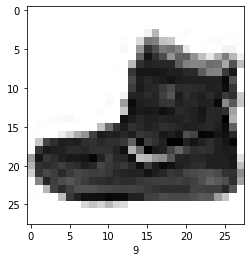

In [72]:
plt.imshow(x_train[0], cmap='binary')
plt.xlabel(y_train[0])
plt.show()

In [73]:
def create_model( hp ):

  num_hidden_layers=1
  num_units=8
  dropout_rate=0.1
  learning_rate=0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers', values=[1,2,3])
    num_units = hp.Choice('num_units', values=[8, 16, 32])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)
    
  model = tf.keras.models.Sequential()
  model.add( tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add( tf.keras.layers.Lambda(lambda x: x/255.))
  for _ in range(0, num_hidden_layers):
    model.add( tf.keras.layers.Dense(num_units, activation='relu'))
    model.add( tf.keras.layers.Dropout(dropout_rate))
  model.add( tf.keras.layers.Dense(10, activation='softmax'))
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model



In [74]:
create_model(None).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [75]:
## IMPORTANT seems customer tuner has bug will cause "Unkown metric val_accuracy" error!
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
    super(CustomTuner, self).run_trial(trial, *args, **kwargs)
    

In [76]:
# tuner = CustomTuner(
#     create_model,
#     objective='val_accuracy', 
#     max_trials=20,
#     directory='logs',
#     project_name='fashion_mnist',
#     overwrite=True
# )
# val_accuracy here means validation accuracy
tuner = keras_tuner.tuners.BayesianOptimization(
    create_model,
    objective='val_accuracy', 
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [77]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [78]:
tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=5, verbose=False)

INFO:tensorflow:Oracle triggered exit


In [79]:
tuner.results_summary()

Results summary
Results in logs/fashion_mnist
Showing 10 best trials
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.28052933724791607
learning_rate: 0.003867675434571133
Score: 0.836899995803833
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.1
learning_rate: 0.0001
Score: 0.8356999754905701
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.1
learning_rate: 0.008892164087220428
Score: 0.8338000178337097
Trial summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
dropout_rate: 0.1
learning_rate: 0.0001
Score: 0.8310999870300293
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.3100612268056797
learning_rate: 0.008982649704845903
Score: 0.8255000114440918
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.4631554681690444
learning_rate: 0.005626352447268734
Score: 0.8252999782562256
Trial summary
Hyperparameters:
num_hid

In [80]:
tuner.results_summary(1)

Results summary
Results in logs/fashion_mnist
Showing 1 best trials
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.28052933724791607
learning_rate: 0.003867675434571133
Score: 0.836899995803833


In [84]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.fit(x_train, y_train, validation_data=( x_test, y_test))
              #callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) ] )

ValueError: ignored